In [18]:
from matplotlib import pyplot as plt
from scipy.stats import iqr
import numpy as np
from skimage.transform import hough_line_peaks, hough_line
from skimage.draw import disk as ps_disk

def plot_hough_transform(matrix, title):
    """
    Apply Hough Transform to the matrix and plot the detected lines.
    """
    # Perform Hough Transform
    hspace, angles, distances = hough_line(matrix)

    # Identify the peaks in the Hough Transform
    hspace_peaks, angles_peaks, dist_peaks = hough_line_peaks(hspace, angles, distances)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax = axes.ravel()

    ax[0].imshow(matrix, cmap=plt.cm.gray)
    ax[0].set_title('Input Image')
    ax[0].set_axis_off()

    ax[1].imshow(matrix, cmap=plt.cm.gray)
    for angle, dist in zip(angles_peaks, dist_peaks):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - matrix.shape[1] * np.cos(angle)) / np.sin(angle)
        ax[1].plot((0, matrix.shape[1]), (y0, y1), '-r')
    ax[1].set_xlim((0, matrix.shape[1]))
    ax[1].set_ylim((matrix.shape[0], 0))
    ax[1].set_title('Detected Lines')
    ax[1].set_axis_off()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    return fig

def plot_angle_distribution(matrix, title):
    """
    Plot the distribution of angles of the detected lines using Hough Transform.
    """
    # Perform Hough Transform
    hspace, angles, distances = hough_line(matrix)

    # Identify the peaks in the Hough Transform
    _, angles_peaks, _ = hough_line_peaks(hspace, angles, distances)

    # Convert angles from radians to degrees
    angles_degrees = np.rad2deg(angles_peaks)

    # Plotting
    fig = plt.figure(figsize=(8, 6))
    plt.hist(angles_degrees, bins=30, range=(-90, 90))
    plt.title(f"Angle Distribution: {title}")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Frequency")
    plt.grid(False)
    plt.show()
    return fig

def calculate_histogram_spread(matrix):
    """
    Calculate various measures of spread for the angle distribution of detected lines in a binary matrix.
    Returns standard deviation, IQR, range, variance, and coefficient of variation.
    """
    # Perform Hough Transform
    hspace, angles, distances = hough_line(matrix)

    # Identify the peaks in the Hough Transform
    _, angles_peaks, _ = hough_line_peaks(hspace, angles, distances)

    # Convert angles from radians to degrees
    angles_degrees = (np.rad2deg(angles_peaks))

    # Calculate statistics
    std_dev = np.std(angles_degrees)
    iqr_value = iqr(angles_degrees)
    range_value = np.ptp(angles_degrees)  # Peak to peak (max - min)
    variance = np.var(angles_degrees)
    cv = std_dev / np.mean(angles_degrees) if np.mean(angles_degrees) != 0 else float('inf')

    return std_dev, iqr_value, range_value, variance, cv

In [2]:
import porespy as ps
def visualize_labeled_matrix(matrix):
    plt.imshow(matrix, cmap='rainbow', interpolation='none')
    plt.colorbar(label='Label')
    plt.rcParams['axes.facecolor'] = 'white'

    # Adding grid lines
    plt.grid(which='both', linestyle='-', linewidth=1)

    plt.title('Labeled Islands')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')

    plt.show()
def generate_lattice_spheres(r, nx, ny, bed_value, volume_fraction=1, clearance = 2, seed = None):
    shape = [nx,int(bed_value*ny)]

    o = 1.25 * r
    s = 3.75 * r

    im = ps.generators.rsa(im_or_shape=shape,volume_fraction=volume_fraction, r=r, clearance=clearance, seed=seed)
    NX,NY = shape
    matrix = np.array(im)
    porosity = ((NX*NY)-np.sum(im))/(NX*NY)
    teste = np.full([nx, int((1-bed_value)*ny)], False)
    save = matrix
    matrix = np.hstack((matrix,teste))
    return teste, matrix, save

[16:42:55] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=118866;file:///home/andreas/.virtualenvs/lbm-jax/lib/python3.10/site-packages/openpnm/utils/_workspace.py\_workspace.py]8;;\:]8;id=459428;file:///home/andreas/.virtualenvs/lbm-jax/lib/python3.10/site-packages/openpnm/utils/_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

In [3]:
def generate_evenly_distributed_triangular_lattice_v2(domain_size, radius, spacing):
    """
    Generate a triangular lattice of spheres within a specified domain with even distribution of gaps.
    """
    # Adjust the horizontal and vertical spacing for the triangular lattice
    horizontal_spacing = spacing
    vertical_spacing = np.sqrt(3) * spacing / 2

    # Calculate the number of spheres that can fit in each dimension
    num_spheres_x = int(domain_size[0] // spacing)
    num_spheres_y = int(domain_size[1] // vertical_spacing)

    # Calculate the total space required for the spheres along each dimension
    total_space_x = num_spheres_x * spacing
    total_space_y = num_spheres_y * vertical_spacing

    # Calculate the extra space to be distributed
    extra_space_x = domain_size[0] - total_space_x
    extra_space_y = domain_size[1] - total_space_y

    # Distribute the extra space evenly across the borders
    start_offset_x = extra_space_x / 2
    start_offset_y = extra_space_y / 2

    # Create an empty domain
    lattice = np.zeros(domain_size, dtype=bool)

    # Generate the lattice
    for i in range(num_spheres_y):
        for j in range(num_spheres_x):
            # Adjust for staggered rows in the triangular lattice
            offset = spacing / 2 if i % 2 == 1 else 0
            center_x = int(j * horizontal_spacing + offset + start_offset_x)
            center_y = int(i * vertical_spacing + start_offset_y)

            # Draw the sphere if it's fully within the domain boundaries
            if center_x - radius >= 0 and center_x + radius < domain_size[0] and \
               center_y - radius >= 0 and center_y + radius < domain_size[1]:
                rr, cc = ps_disk((center_y, center_x), radius, shape=domain_size)
                lattice[rr, cc] = True

    return lattice
def generate_evenly_distributed_sc_lattice(domain_size, radius, spacing):
    """
    Generate a simple cubic (sc) lattice of spheres within a specified domain with even distribution of gaps.
    """
    # The spacing is the same in all directions for a simple cubic lattice
    spacing_x = spacing_y = spacing

    # Calculate the number of spheres that can fit in each dimension
    num_spheres_x = int(domain_size[0] // spacing_x)
    num_spheres_y = int(domain_size[1] // spacing_y)

    # Calculate the total space required for the spheres along each dimension
    total_space_x = num_spheres_x * spacing_x
    total_space_y = num_spheres_y * spacing_y

    # Calculate the extra space to be distributed
    extra_space_x = domain_size[0] - total_space_x
    extra_space_y = domain_size[1] - total_space_y

    # Distribute the extra space evenly across the borders
    start_offset_x = extra_space_x / 2
    start_offset_y = extra_space_y / 2

    # Create an empty domain
    lattice = np.zeros(domain_size, dtype=bool)

    # Generate the lattice
    for i in range(num_spheres_y):
        for j in range(num_spheres_x):
            center_x = int(j * spacing_x + start_offset_x)
            center_y = int(i * spacing_y + start_offset_y)

            # Draw the sphere if it's fully within the domain boundaries
            if center_x - radius >= 0 and center_x + radius < domain_size[0] and \
               center_y - radius >= 0 and center_y + radius < domain_size[1]:
                rr, cc = ps_disk((center_y, center_x), radius, shape=domain_size)
                lattice[rr, cc] = True

    return lattice
# Generate the evenly distributed triangular lattice

In [4]:
def porosity(matrix):
    x,y = matrix.shape
    
    return ((x*y) - np.sum(matrix))/(x*y)

In [5]:
nx = 400
ny = 800
r = 10
bed_value = 0.5
matrix_1 = generate_evenly_distributed_sc_lattice(domain_size=(400, 400), radius=10, spacing=26)
matrix_2 = generate_evenly_distributed_triangular_lattice_v2(domain_size=(400, 400), radius=10, spacing=28)
_,_,matrix_3 = generate_lattice_spheres(r,nx,ny,bed_value,volume_fraction=0.4 , seed= 123)
_,_,matrix_4 = generate_lattice_spheres(r,nx,ny,bed_value, volume_fraction=0.4, seed= 125)
_,_,matrix_5 = generate_lattice_spheres(r,nx,ny,bed_value, volume_fraction=0.4, seed= 122)
domains = [matrix_1,matrix_2,matrix_3,matrix_4, matrix_5]


/tmp/ipykernel_832/4209801187.py:21: DeprecationWarning: Call to deprecated function (or staticmethod) rsa. (This function will be renamed random_spheres in a future version)
  im = ps.generators.rsa(im_or_shape=shape,volume_fraction=volume_fraction, r=r, clearance=clearance, seed=seed)
/tmp/ipykernel_832/4209801187.py:21: DeprecationWarning: Call to deprecated function (or staticmethod) rsa. (This function will be renamed random_spheres in a future version)
  im = ps.generators.rsa(im_or_shape=shape,volume_fraction=volume_fraction, r=r, clearance=clearance, seed=seed)


In [6]:
def plot_input_and_magnitude_spectrum(image):

    # Calculate the magnitude spectrum
    magnitude_spectrum = calculate_magnitude_spectrum(image)

    # Plot the original image and its magnitude spectrum side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original Image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Magnitude Spectrum
    axes[1].imshow(magnitude_spectrum, cmap='gray')
    axes[1].set_title('Magnitude Spectrum')
    axes[1].axis('off')

    plt.show()


In [7]:
import numpy as np
from numpy.fft import fftshift, fft2

def calculate_magnitude_spectrum(image):
    # Applying Fourier Transform on the matrix
    # Fourier Transform
    f_transform = fft2(image)
    # Shifting zero frequency component to the center
    f_transform_shifted = fftshift(f_transform)
    # Magnitude Spectrum
    magnitude_spectrum = np.log(np.abs(f_transform_shifted) + 1)  # Adding 1 to avoid log(0)
    return magnitude_spectrum


def calculate_fourier_statistics(image):
    magnitude_spectrum = calculate_magnitude_spectrum(image)

    statistics = {}

    # Mean and Standard Deviation
    mean_magnitude = np.mean(magnitude_spectrum)
    std_deviation_magnitude = np.std(magnitude_spectrum)

    # Maximum and Minimum Magnitude
    max_magnitude = np.max(magnitude_spectrum)
    min_magnitude = np.min(magnitude_spectrum)

    # Total Energy
    total_energy = np.sum(np.abs(magnitude_spectrum) ** 2)

    # Peak Frequency Component
    peak_frequency = np.unravel_index(np.argmax(magnitude_spectrum), magnitude_spectrum.shape)

    # Center of Mass
    row_cms, col_cms = np.indices(magnitude_spectrum.shape)
    centroid_row = np.sum(row_cms * magnitude_spectrum) / np.sum(magnitude_spectrum)
    centroid_col = np.sum(col_cms * magnitude_spectrum) / np.sum(magnitude_spectrum)

    # Additional metrics for regularity
    spectral_entropy = np.sum(magnitude_spectrum * np.log(magnitude_spectrum))  # Spectral Entropy
    pslr = max_magnitude / np.mean(magnitude_spectrum)  # Peak-to-Sidelobe Ratio
    # You can add more metrics here (e.g., radial average power spectrum, fractal dimension, HNR, local contrast, etc.)

    statistics["Mean Magnitude"] = mean_magnitude
    statistics["Std Deviation Magnitude"] = std_deviation_magnitude
    statistics["Maximum Magnitude"] = max_magnitude
    statistics["Minimum Magnitude"] = min_magnitude
    statistics["Total Energy"] = total_energy
    statistics["Peak Frequency Component"] = peak_frequency
    statistics["Centroid (Row)"] = centroid_row
    statistics["Centroid (Col)"] = centroid_col
    statistics["Spectral Entropy"] = spectral_entropy
    statistics["Peak-to-Sidelobe Ratio"] = pslr
    # Add more metrics to the dictionary as needed

    return statistics

MATRIX 1
Matrix 1, porosity: 0.626375
Hough Transform


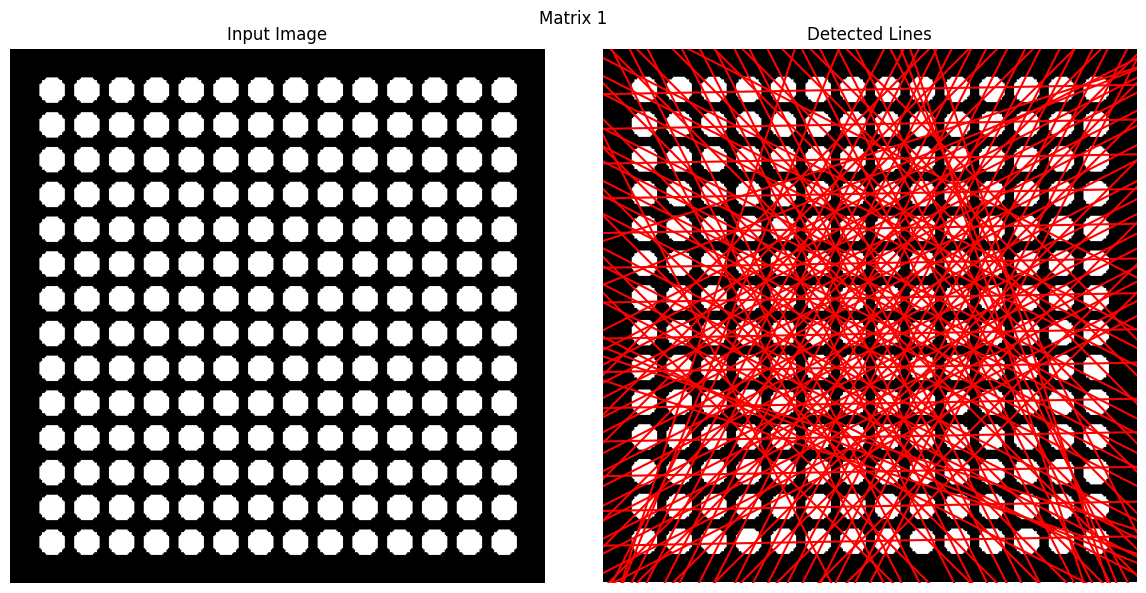

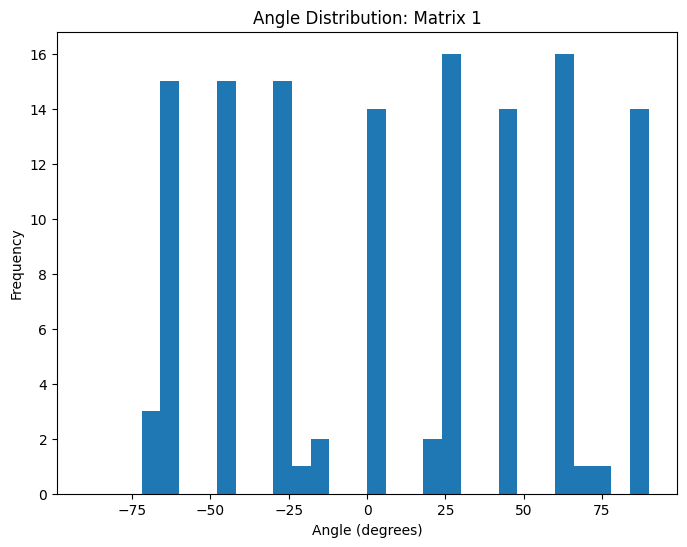

(50.64051729067209, 90.0, 161.0, 2564.461991466859, 5.439322839714155)
Fourier Transform


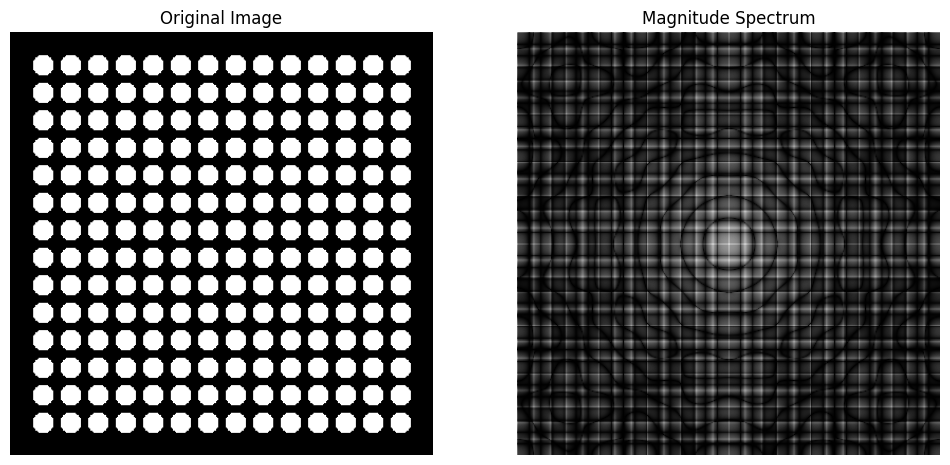

Mean Magnitude: 3.685033604350806
Std Deviation Magnitude: 1.2814892114464003
Maximum Magnitude: 12.492269861947287
Minimum Magnitude: 0.003492005140361738
Total Energy: 2435469.9622797132
Peak Frequency Component: (200, 200)
Centroid (Row): 199.5373226943502
Centroid (Col): 199.53732269435017
Spectral Entropy: 807860.4140731773
Peak-to-Sidelobe Ratio: 3.3900016127934487
-----------------------------------------------------
MATRIX 2
Matrix 2, porosity: 0.61303125
Hough Transform


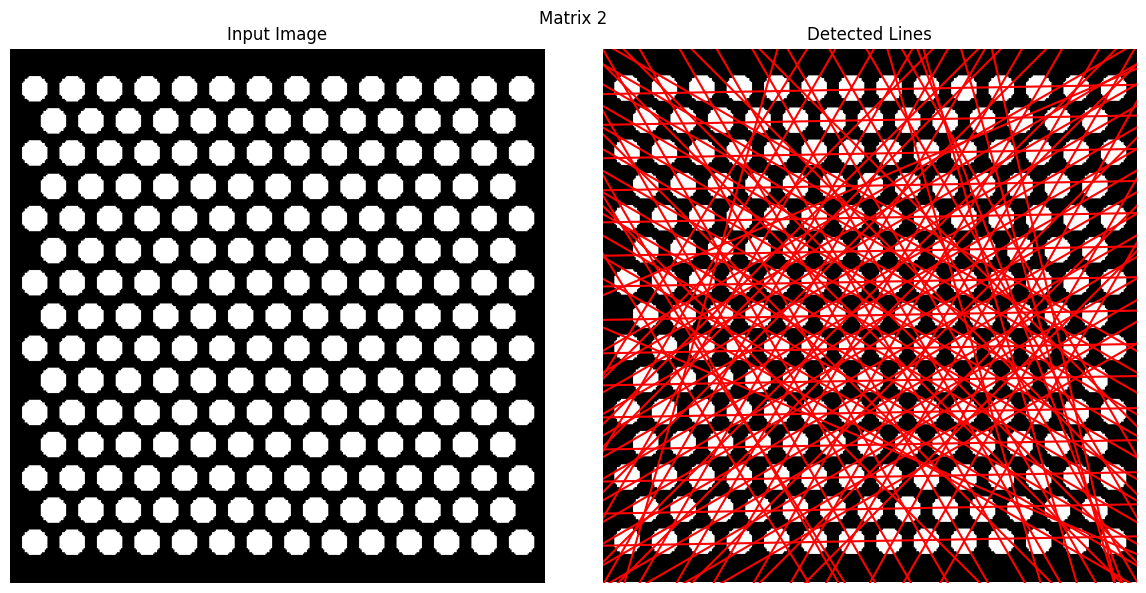

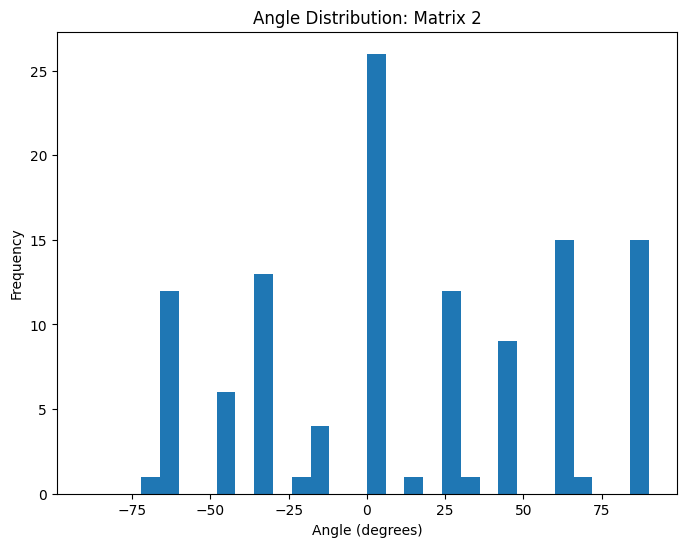

(47.08160135405127, 90.00000000000001, 156.0, 2216.6771860618023, 3.4842171780037945)
Fourier Transform


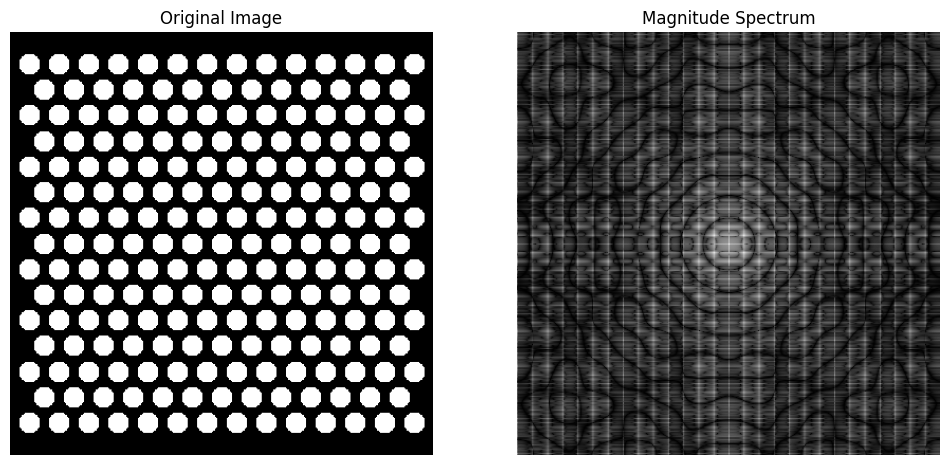

Mean Magnitude: 3.9482853505404054
Std Deviation Magnitude: 1.2840921671952295
Maximum Magnitude: 12.749214794944812
Minimum Magnitude: 0.0013910684722421981
Total Energy: 2758055.9845030596
Peak Frequency Component: (200, 200)
Centroid (Row): 199.53061607648885
Centroid (Col): 199.51092704477307
Spectral Entropy: 904093.2019818709
Peak-to-Sidelobe Ratio: 3.2290510089904765
-----------------------------------------------------
MATRIX 3
Matrix 3, porosity: 0.5996875
Hough Transform


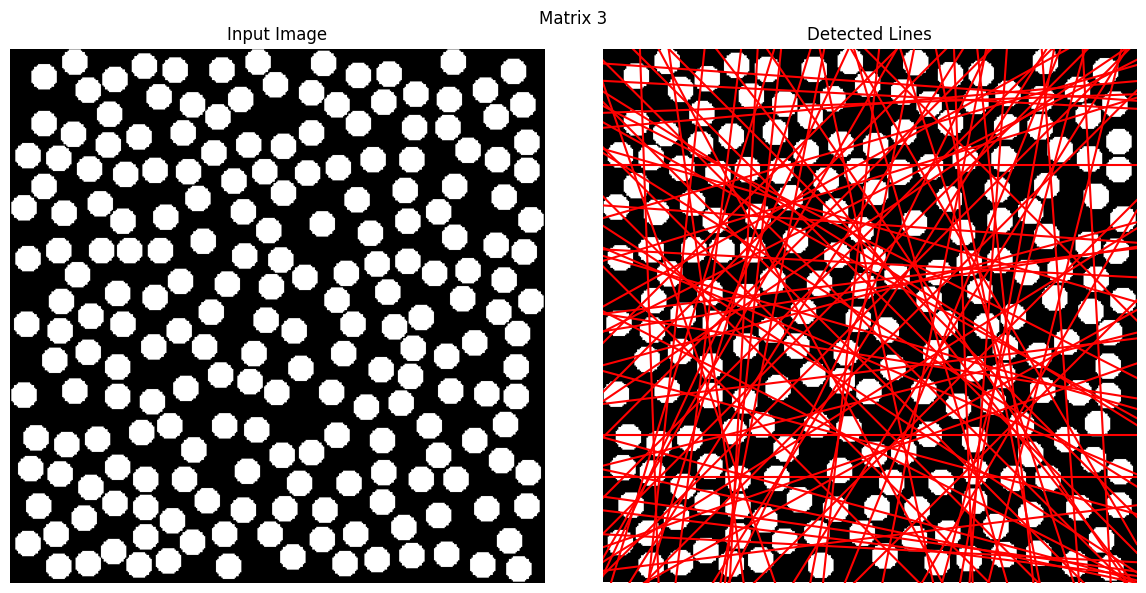

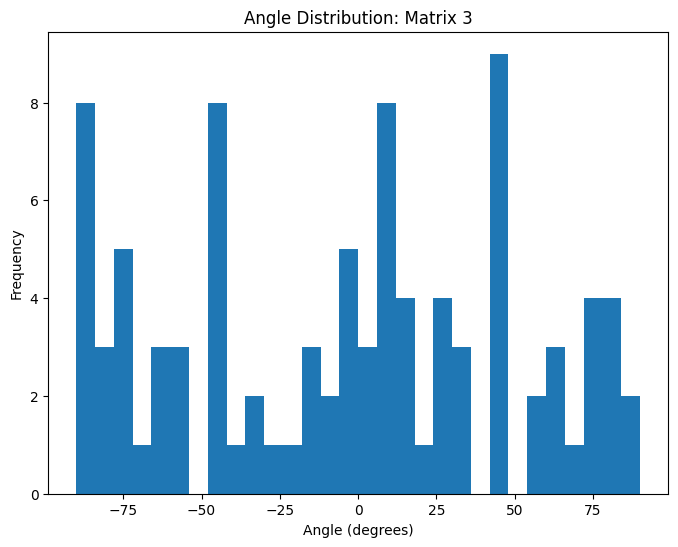

(53.632503674824456, 90.0, 178.0, 2876.4454504300584, -12.603638363583748)
Fourier Transform


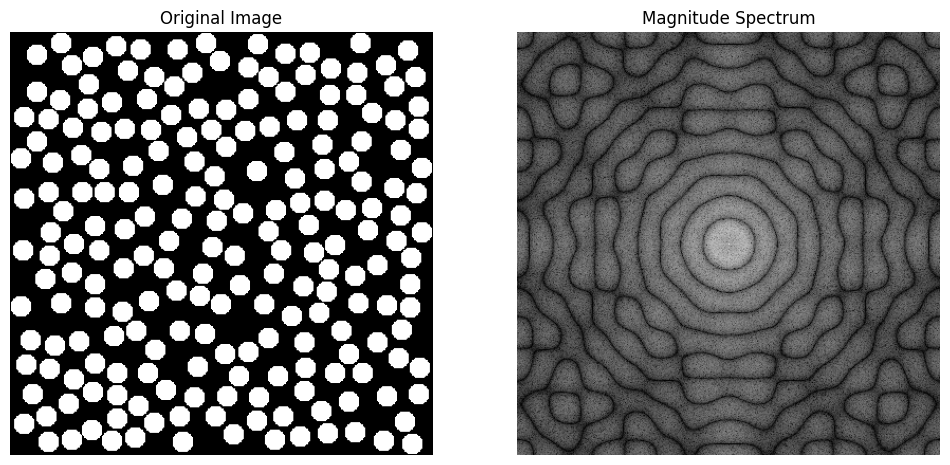

Mean Magnitude: 4.973243300138981
Std Deviation Magnitude: 1.133527316241422
Maximum Magnitude: 13.219198672923591
Minimum Magnitude: 0.001214531291076134
Total Energy: 4162885.2958468394
Peak Frequency Component: (200, 200)
Centroid (Row): 199.50529820998554
Centroid (Col): 199.50516136101794
Spectral Entropy: 1299929.4887207863
Peak-to-Sidelobe Ratio: 2.6580639383868814
-----------------------------------------------------
MATRIX 4
Matrix 4, porosity: 0.5996875
Hough Transform


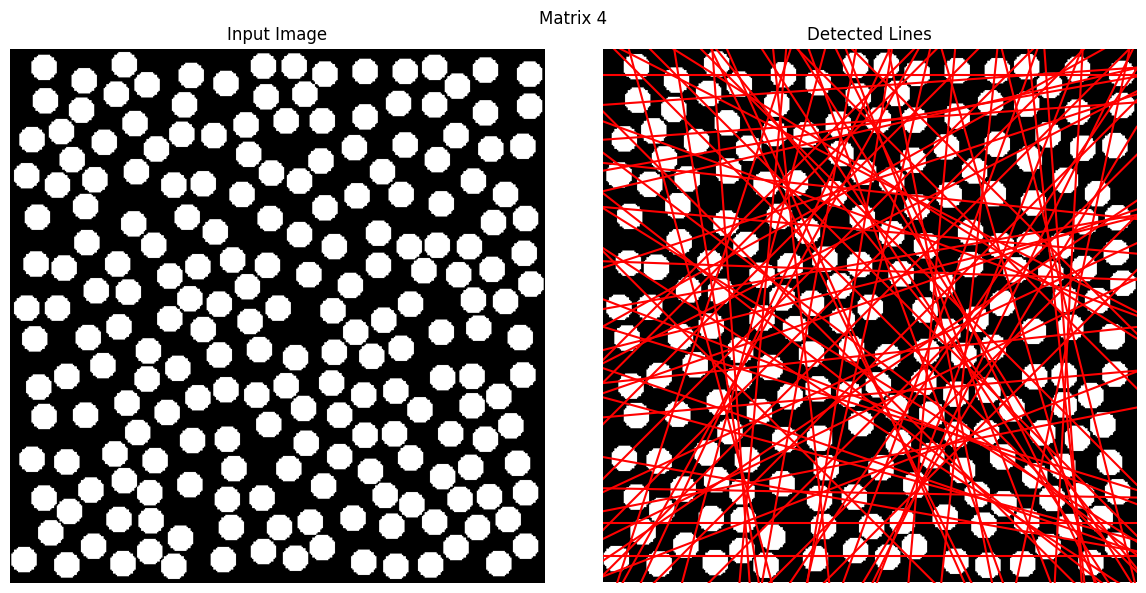

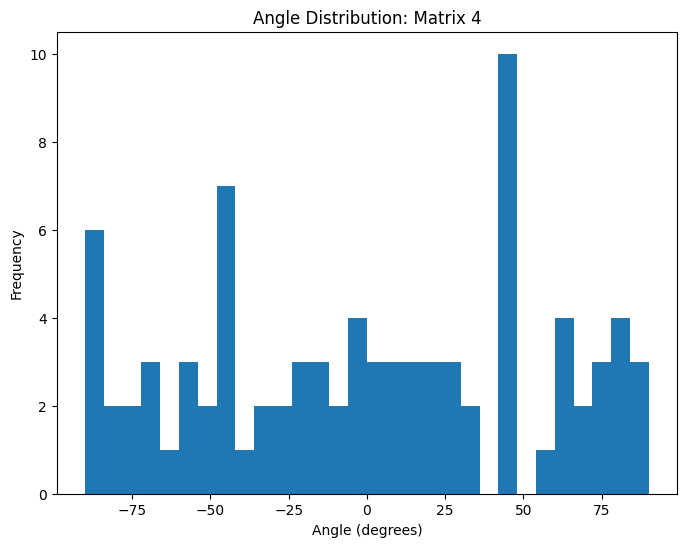

(53.3640344651298, 90.0, 176.0, 2847.7201743955607, -154.75569994887675)
Fourier Transform


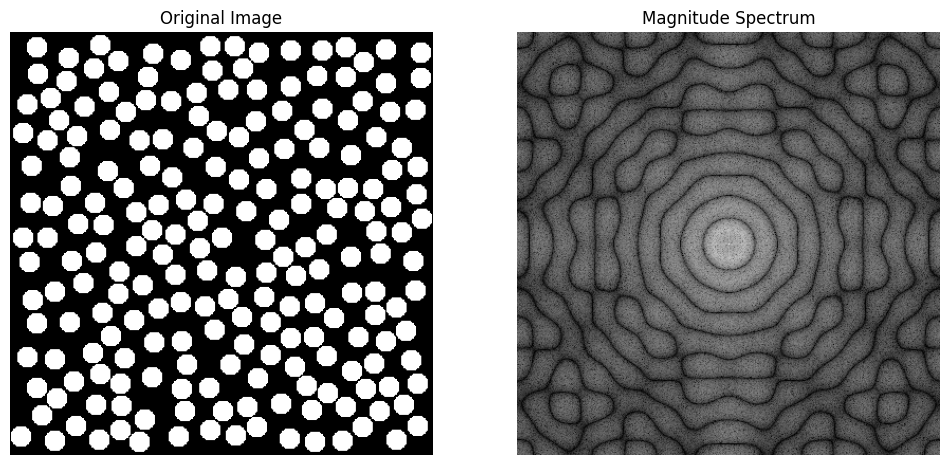

Mean Magnitude: 4.971441948921243
Std Deviation Magnitude: 1.127095282835924
Maximum Magnitude: 13.220529666602815
Minimum Magnitude: 0.0008253866220655771
Total Energy: 4157692.6124935737
Peak Frequency Component: (200, 200)
Centroid (Row): 199.51296089048884
Centroid (Col): 199.5090493565689
Spectral Entropy: 1298848.0420261344
Peak-to-Sidelobe Ratio: 2.6592947886018354
-----------------------------------------------------
MATRIX 5
Matrix 5, porosity: 0.5996875
Hough Transform


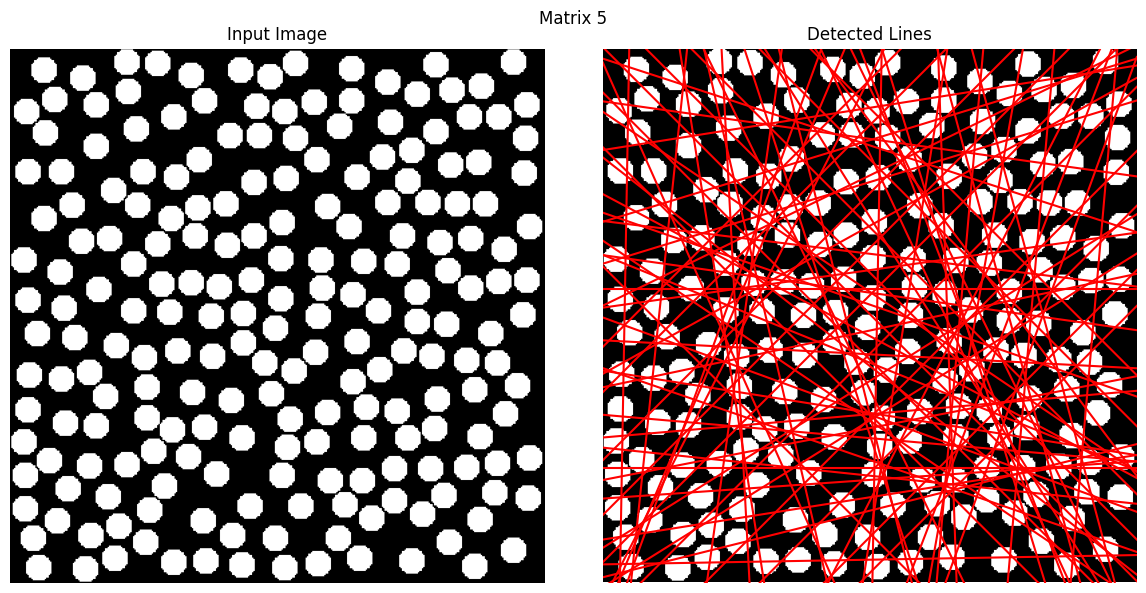

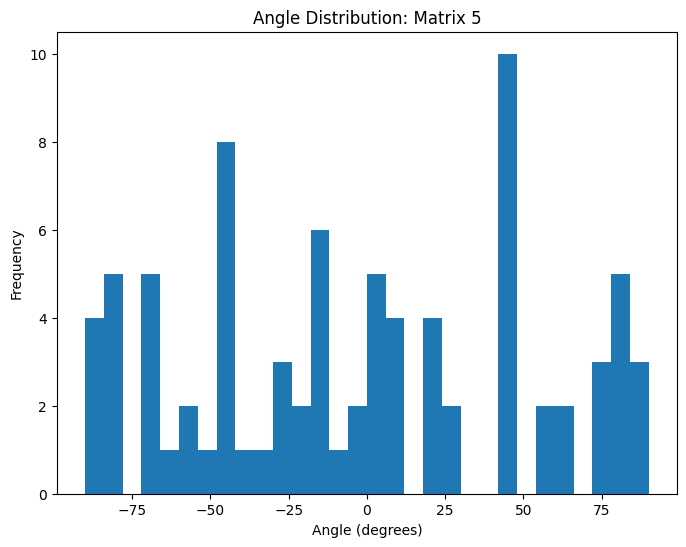

(53.47782902756513, 90.0, 179.0, 2859.878197501487, -18.50287755384111)
Fourier Transform


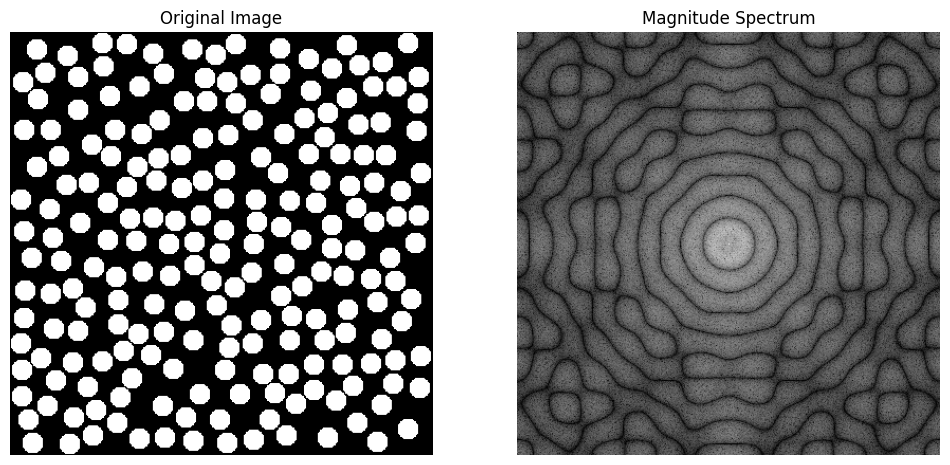

Mean Magnitude: 4.96602550759962
Std Deviation Magnitude: 1.135807974737487
Maximum Magnitude: 13.22033885932104
Minimum Magnitude: 9.03317392030476e-05
Total Energy: 4152235.055617175
Peak Frequency Component: (200, 200)
Centroid (Row): 199.4991380659104
Centroid (Col): 199.52048609528794
Spectral Entropy: 1297045.0816496192
Peak-to-Sidelobe Ratio: 2.662156857448609
-----------------------------------------------------


In [19]:
for idx,matrix in enumerate(domains):
    print(f"MATRIX {idx +1}")
    np.save(f"matrix_{idx+1}.npy", matrix)
    print(f"Matrix {idx+1}, porosity:", porosity(matrix))

    print("Hough Transform")
    fig  = plot_hough_transform(matrix, f"Matrix {idx+1}")
    fig.savefig(f'data/hough_domain_{idx+1}',dpi=300, bbox_inches='tight')
    calculate_histogram_spread(matrix)
    hist = plot_angle_distribution(matrix, f"Matrix {idx+1}")
    hist.savefig(f'data/hough_hist_{idx+1}',dpi=300, bbox_inches='tight')
    print(calculate_histogram_spread(matrix))
    
    print("Fourier Transform")

    magnitude_spectrum = calculate_magnitude_spectrum(matrix)
    plot_input_and_magnitude_spectrum(matrix)
    statistics = calculate_fourier_statistics(magnitude_spectrum)
    for key, value in statistics.items():
        print(f"{key}: {value}")
    print ("-----------------------------------------------------")